In [12]:
import pytest
import torch
from torch import einsum, nn
import triton
import triton.language as tl
from triton_testing.multihead_attention import multihead_flash_attention
from triton_testing.multiquery_attention import multiquery_flash_attention
from triton_testing.query_norm import fused_query_norm, naive_query_norm

In [13]:
def test_multiquery_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float16):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    # triton implementation
    tri_out = multiquery_flash_attention(q, k, v)
    # reference implementation
    k = k.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    v = v.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    ref_out = multihead_flash_attention(q,k,v)
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)
    print("Passed all equality checks")

In [14]:
test_multiquery_op(3, 2, 2048, 64)

Passed


In [15]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['multiquery_flash_attention','multihead_flash_attention'],
    line_names=['Multiquery Attention','Multihead Attention'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd']]


@triton.testing.perf_report(configs)
def bench_flash_multiquery_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    if provider == "multiquery_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        fn = lambda: multiquery_flash_attention(q, k, v)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "multihead_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = k.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        v = v.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        fn = lambda: multihead_flash_attention(q, k, v)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms

fused-attention-batch4-head24-d64-fwd:
     N_CTX  Multiquery Attention  Multihead Attention
0   1024.0              0.194086             0.185031
1   2048.0              0.534675             0.551729
2   4096.0              1.857497             1.892785
3   8192.0              6.931968             6.980827
4  16384.0             26.821632            26.874197
5  32768.0            105.346046           105.565186


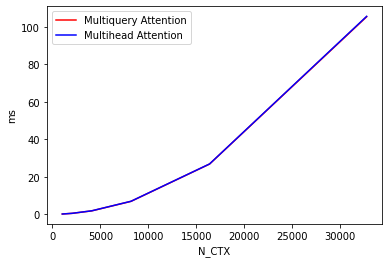

In [9]:
bench_flash_multiquery_attention.run(save_path='.', print_data=True)

In [16]:
def test_querynorm_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float32):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-6
    # naive torch implementation
    naive_out = naive_query_norm(q, w, b, eps)
    # triton implementation
    tri_out = fused_query_norm(q, w.flatten(), b.flatten(), eps)
    tri_out.backward(dy, retain_graph=True)
    dq_tri, dw_tri, db_tri = [_.grad.clone() for _ in [q, w, b]]
    q.grad, w.grad, b.grad = None, None, None
    # backward pass (torch)
    naive_out.backward(dy, retain_graph=True)
    dq_ref, dw_ref, db_ref = [_.grad.clone() for _ in [q, w, b]]
    # compare
    triton.testing.assert_almost_equal(naive_out, tri_out)
    triton.testing.assert_almost_equal(dq_tri, dq_ref)
    triton.testing.assert_almost_equal(db_tri, db_ref)
    triton.testing.assert_almost_equal(dw_tri, dw_ref)
    print("Passed all equality checks")

In [17]:
test_querynorm_op(3, 2, 2048, 64)

In [20]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
configs = [triton.testing.Benchmark(
    x_names=['D_HEAD'],
    x_vals=[512 * i for i in range(2, 16)],
    line_arg='provider',
    line_vals=['triton', 'torch'],
    line_names=['Triton QueryNorm', 'Torch QueryNorm'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name=f'query-norm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'N_CTX': N_CTX, 'dtype': torch.float16, 'mode': mode}
) for mode in ['forward', 'backward']]

@triton.testing.perf_report(configs)
def bench_query_norm(BATCH, H, N_CTX, D_HEAD, dtype, provider, mode='forward', eps=1e-5, device='cuda'):
    # create data
    q_shape = (BATCH, H, N_CTX, D_HEAD)
    w_shape = (1,H,1,1)
    w = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    q = torch.randn(q_shape, dtype=dtype, device='cuda')
    q.requires_grad_(True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-5
    # utility functions
    if provider == 'triton':
        y_fwd = lambda: fused_query_norm(q, w.flatten(), b.flatten(), eps)
    if provider == 'torch':
        y_fwd = lambda: naive_query_norm(q, w, b, eps)
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * q.numel() * q.element_size() / ms * 1e-6
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, rep=500)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * q.numel() * q.element_size() / ms * 1e-6
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True),
                                                     grad_to_none=[q], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

query-norm-forward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1330.680162       185.042813
1   1536.0       1147.517479       187.364677
2   2048.0       1357.087170       188.006696
3   2560.0       1285.019601       188.484325
4   3072.0       1354.360511       189.334401
5   3584.0       1374.881043       189.645306
6   4096.0       1393.147941       187.435371
7   4608.0       1318.042480       190.347676
8   5120.0       1353.117683       190.705666
9   5632.0       1334.580686       189.684521
10  6144.0       1383.751365       190.365599
11  6656.0       1386.441046       190.525824
12  7168.0       1391.211490       190.620469
13  7680.0       1350.638896       190.739581
query-norm-backward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1170.285724        99.725083
1   1536.0       1226.245284       100.247696
2   2048.0       1259.634849       100.622513
3   2560.0       1289.514675       100.631952
4   3072.0       1294.893482       100.

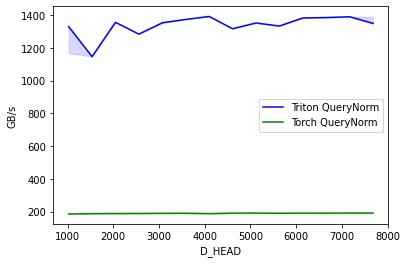

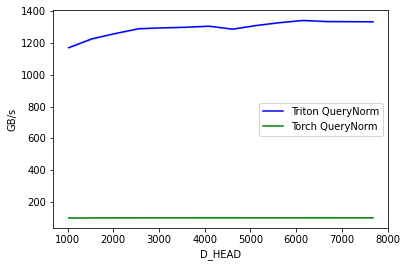

In [21]:
bench_query_norm.run(save_path='.', print_data=True)